In [43]:
import sqlite3, os, sys, pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### First let's inspect the data and how to interact with the sql db file

In [2]:
db_path = "db_files/rasmus_classification_muon_3neutrino_3mio.db"
conn = sqlite3.connect(db_path) # this simply connects everything to the .db file. Can be used withs pandas read_sql
cursor = conn.cursor() # used as a cursor from where we can execute commands and interact more directly with the db
## for example ##
cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table';")
## General syntax is select feature from tablefile (features/truth) where condition limit x offset start

## e.g. "select distinct event_no from truth where pid = 13 limit 1 offset {n_data}"

In [4]:
lim=int(1e5)
# getting truth for all events (there are 3 milllion so you can turn it down with limit)
df_true=pd.read_sql(f'select * from truth ORDER BY RANDOM() limit {lim}', conn)
stop=df_true.iloc[-1]['event_no']

In [21]:
min(np.unique(df_all.loc[df_all['pid']==13]['event_no']))

138674340

In [37]:
#you should only do this if you really want some randomized data it takes forever but not a lot of memory
ids=df_true['event_no'].to_numpy()
ids=[str(idd) for idd in ids]
df_features=pd.read_sql(f'select * from features where event_no is {str(ids[0])}', conn)
for i in tqdm(range(1,len(ids))):
    df0=pd.read_sql(f'select * from features where event_no is {str(ids[i])}', conn)
    df_features.append(df0, ignore_index=1)

In [84]:
id0=tuple(df_true['event_no'])
df_features1=pd.read_sql(f'select * from features WHERE event_no IN {id0}', conn)

In [ ]:
#if not random
# df_features=pd.read_sql(f'select * from features where event_no<={stop}', conn)

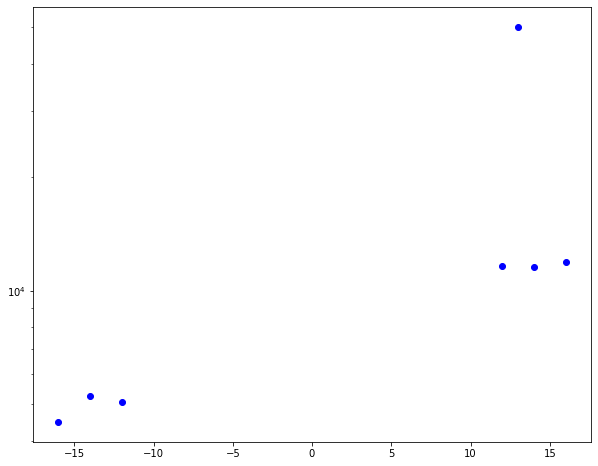

In [39]:
#investigating particle types, pid is particle identification, - indicates antiparticle
#12=electron neutrino, 13=muon, 14=muon neutrino, 16=tau neutrino
pids=df_true['pid'].to_numpy()
ptypes, counts = np.unique(pids, return_counts=True)
fig, ax=plt.subplots(figsize=(10,8))
ax.plot(ptypes, counts, 'bo')
ax.set(yscale='log');
#by far the largest part is pure muons.

In [52]:
transformers = pd.read_pickle("data/transformers.pkl")
trans_x      = transformers['features']
trans_y      = transformers['truth']


for col in transformers['features'].keys():
    df_features[col] = trans_x[col].inverse_transform(np.array(df_features[col]).reshape(1, -1)).T

for col in transformers['truth'].keys():
    df_true[col] = trans_y[col].inverse_transform(np.array(df_true[col]).reshape(1, -1)).T

Taking a look a the different distributions for truth and features

1. truth 
2. features

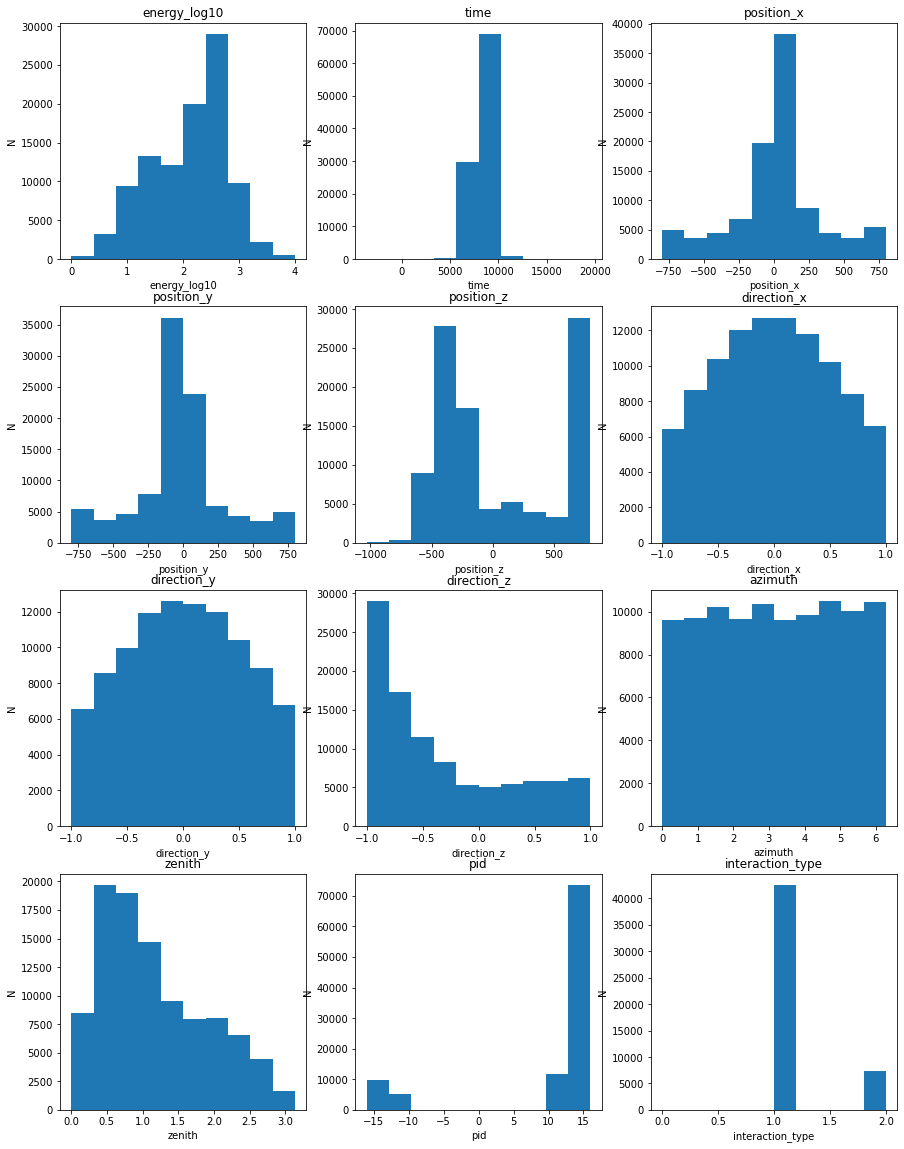

In [68]:
# note that so far we have worked on scaled stuff, not it's scaled to the real values!
fig, ax=plt.subplots(ncols=3,nrows=4, figsize=(15,20))
ax=ax.flatten()
for i, col in enumerate(df_true.columns):
    if i!=0 and i<=12:
        ax[i-1].hist(df_true[col], label=col)
        ax[i-1].set(title=col, xlabel=col, ylabel='N')
        
fig.tight_layout()

In [56]:
df_true.describe()

,event_no,energy_log10,time,position_x,position_y,position_z,direction_x,direction_y,direction_z,azimuth,zenith,pid,interaction_type,muon_track_length,stopped_muon
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,49887.000000,6.528000e+04,65280.000000
mean,1.330415e+08,2.102847,8754.977145,24.422928,-22.208913,70.165377,-0.001276,0.006228,-0.326238,3.176229,1.174318,9.37383,1.146271,1.070471e+03,0.750184
std,7.778542e+06,0.685835,1118.145679,325.233232,322.311290,520.170537,0.514643,0.517793,0.600475,1.815502,0.732870,9.78639,0.353834,4.961747e+03,0.432910
min,1.201029e+08,0.003374,-3670.290235,-799.999993,-799.999996,-1030.507048,-0.999988,-0.999971,-0.999994,0.000027,0.003361,-16.00000,0.000000,0.000000e+00,0.000000
25%,1.246497e+08,1.560188,7814.511891,-88.549656,-130.994215,-373.530857,-0.407713,-0.400964,-0.836461,1.607796,0.580003,12.00000,1.000000,5.056100e+02,1.000000
50%,1.386789e+08,2.283100,9150.250750,40.560181,-35.285448,-193.373447,-0.003106,0.007113,-0.543773,3.170852,0.995870,13.00000,1.000000,9.926311e+02,1.000000
75%,1.396160e+08,2.597746,9725.827989,138.463524,81.911551,800.000000,0.404658,0.418358,0.143663,4.763045,1.714958,13.00000,1.000000,1.488438e+03,1.000000
max,1.405476e+08,3.999861,19549.562017,799.999998,799.999998,800.000000,0.999987,0.999998,0.999974,6.282975,3.134412,16.00000,2.000000,1.105883e+06,1.000000


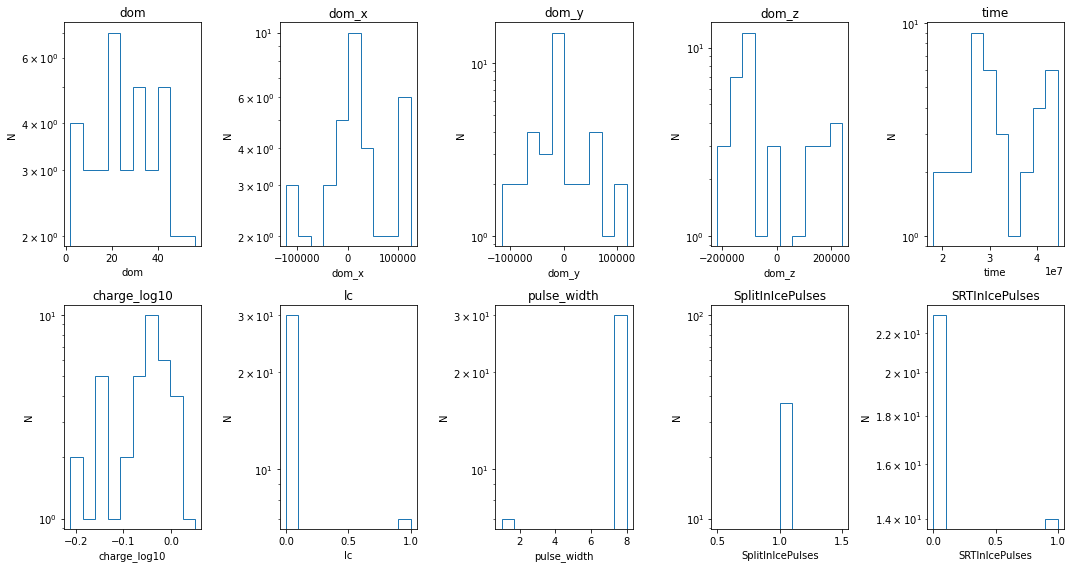

In [89]:
# only select the good stuff
in_feat=['dom', 'dom_x', 'dom_y', 'dom_z','time',
       'charge_log10', 'lc', 'pulse_width', 'SplitInIcePulses',
       'SRTInIcePulses']
fig, ax=plt.subplots(ncols=5,nrows=2, figsize=(15,8))
ax=ax.flatten()
for i, col in enumerate(in_feat):
    ax[i].hist(df_features[col], label=col, histtype='step')
    ax[i].set(title=col, xlabel=col, ylabel='N', yscale='log')
        
fig.tight_layout()

In [74]:
df_features.describe()

,row,event_no,string,dom,pmt,dom_x,dom_y,dom_z,pmt_x,pmt_y,pmt_z,pmt_area,pmt_type,time,charge_log10,lc,pulse_width,SplitInIcePulses,SRTInIcePulses
count,3.700000e+01,37.0,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.0,37.0,37.0,37.0000,37.0,3.700000e+01,37.000000,37.000000,37.000000,37.0,37.000000
mean,5.639747e+07,124899733.0,53.189189,27.378378,0.0,17655.368058,-7639.982693,-32400.231790,0.0,0.0,-1.0,0.0444,20.0,3.200078e+07,-0.062973,0.189189,6.675676,1.0,0.378378
std,1.082436e+01,0.0,27.175191,14.922674,0.0,66502.761431,52752.710104,144619.544740,0.0,0.0,0.0,0.0000,0.0,7.619681e+06,0.060436,0.397061,2.779429,0.0,0.491672
min,5.639746e+07,124899733.0,3.000000,2.000000,0.0,-121460.575342,-115035.847382,-218438.176805,0.0,0.0,-1.0,0.0444,20.0,1.806161e+07,-0.211463,0.000000,1.000000,1.0,0.000000
25%,5.639746e+07,124899733.0,28.000000,18.000000,0.0,-2346.843256,-26740.486340,-131954.949462,0.0,0.0,-1.0,0.0444,20.0,2.703849e+07,-0.089819,0.000000,8.000000,1.0,0.000000
50%,5.639747e+07,124899733.0,58.000000,27.000000,0.0,7752.224932,-17444.729207,-114183.953725,0.0,0.0,-1.0,0.0444,20.0,2.915180e+07,-0.043141,0.000000,8.000000,1.0,0.000000
75%,5.639748e+07,124899733.0,79.000000,39.000000,0.0,61270.128962,10318.405866,104945.310600,0.0,0.0,-1.0,0.0444,20.0,3.993701e+07,-0.025247,0.000000,8.000000,1.0,1.000000
max,5.639749e+07,124899733.0,86.000000,56.000000,0.0,124711.916008,116990.435549,239739.400044,0.0,0.0,-1.0,0.0444,20.0,4.438766e+07,0.050151,1.000000,8.000000,1.0,1.000000


## We can also take a look at some of the distributions Mads Ehrhorn had already made

In [48]:
distributions = pd.read_pickle("data/distributions.pkl")